# Створення базових моделей

**Частина 1**

Необхідно визначити в коді натупне:

1. Базову модель для навчання (виберіть який тип моделі хочете натренувати CNN, MLP тощо).
2. Початкову кількість шарів та їх параметри.
3. Функції для тренування та валідації, візуалізації результатів, фінкцію втрат та метрику перевірки результатів.
4. Натренуйте модель і перевірте результат. Яке значення функції втрат, яка метрика вашої моделі після навчання? Візуалізуйте графіки навчання. Скільки часу потрібно було на тренування?

**Частина 2**

1. Опишіть гіперпараметри моделі: кількість шарів/кількість нейронів в шарах, різні їх комбінації.
2. Підберіть та перевірте найкращі гіперпараметри вашої моделі за яких метрика під час валідації буде найвищою. Скільки часу потрібно було на підбір гіперпараметрів моделі?
3. Продемонструйте на яких класах та зображеннях найчастіше помиляється найкраща модель.
4. Візуалізувати графіки залежностей між гіперпараметрами найкращої моделі і змінами значень її метрики.

In [ ]:
# TODO visualize train/valid results - plot loss and accuracy through EPOCHS
# TODO time execution
# TODO time hyperparams search
# TODO most unpredictable class
# TODO hyperparams/accuracy plot

In [1]:
%pip install optuna torch matplotlib torchvision


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
datasets_path = './datasets'

train_dataset = FashionMNIST(
    datasets_path,
    train=True,
    download=True,
    transform=transform
)
validation_dataset = FashionMNIST(
    datasets_path,
    train=False,
    transform=transform
)

In [5]:
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(dataset=validation_dataset, shuffle=False)

In [6]:
plt_size = 2
plt_images = 8
IMAGE_SIZE = 28
CLASSES_N = len(set([i.item() for x,y in train_loader for i in y]))
EPOCHS = 50
N_TRAIN_EXAMPLES=20
N_VALID_EXAMPLES=20

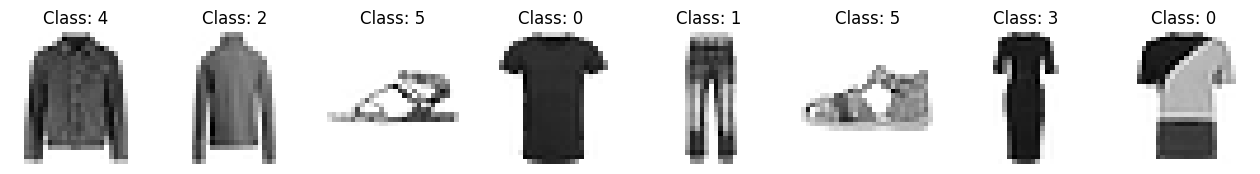

In [7]:
for (X_train, y_train) in train_loader:
    plt.figure(figsize=(plt_images * plt_size, plt_size))

    for i in range(plt_images):
        plt.subplot(1, plt_images, i + 1)
        plt.axis('off')
        plt.imshow(X_train[i, :, :, :].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray_r")
        plt.title(f'Class: {y_train[i].item()}')

    break

In [8]:
from optuna.trial import TrialState, Trial

def define_model(trial: Trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    conv_kernel_3 = 3
    pool_kernel_2 = 2

    in_features = 1
    image_size = [IMAGE_SIZE, IMAGE_SIZE]
    for i in range(n_layers):
        out_features = trial.suggest_int(f'n_units_l{i}', 4, 128, 2)
        layers.append(torch.nn.Conv2d(in_features, out_features, kernel_size=conv_kernel_3, stride=1, padding=(conv_kernel_3 - 1) // 2))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.MaxPool2d(kernel_size=pool_kernel_2, stride=pool_kernel_2))
        in_features = out_features
        image_size[0] //= pool_kernel_2
        image_size[1] //= pool_kernel_2

    layers.append(torch.nn.Flatten())
    layers.append(torch.nn.Linear(in_features * image_size[0] * image_size[1], CLASSES_N))
    layers.append(torch.nn.LogSoftmax(dim=1))

    return torch.nn.Sequential(*layers)


/Users/mp/.pyenv/versions/3.10.10/envs/kma-nn-3.10.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# CNN - Початкову кількість шарів та їх параметри.
# CNN: spatial relationships, translation-invariant features
import torch
import optuna
import torch.nn.functional as F


def objective(trial):
    # Generate the model.
    model = define_model(trial).to(device)
    print(model)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    
    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (X_train, y_train) in enumerate(train_loader):
            if batch_idx * len(X_train) >= N_TRAIN_EXAMPLES:
                break
            data, target = X_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (X_valid, y_valid) in enumerate(validation_loader):
                if batch_idx * len(X_valid) >= N_VALID_EXAMPLES:
                    break
                data, target = X_valid.to(device), y_valid.to(device)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(validation_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy




In [10]:

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-11-02 20:15:13,859] A new study created in memory with name: no-name-a0fa7790-d8da-45fd-ba22-5182e82163b9


Sequential(
  (0): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(100, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1274, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:16,141] Trial 0 finished with value: 0.65 and parameters: {'n_layers': 2, 'n_units_l0': 100, 'n_units_l1': 26, 'optimizer': 'SGD', 'lr': 0.03255780119778772}. Best is trial 0 with value: 0.65.


Sequential(
  (0): Conv2d(1, 52, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(52, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=980, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:17,955] Trial 1 finished with value: 0.1 and parameters: {'n_layers': 2, 'n_units_l0': 52, 'n_units_l1': 20, 'optimizer': 'Adam', 'lr': 1.6583314003143105e-05}. Best is trial 0 with value: 0.65.


Sequential(
  (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(128, 76, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(76, 124, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=1116, out_features=10, bias=True)
  (11): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:21,538] Trial 2 finished with value: 0.6 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 76, 'n_units_l2': 124, 'optimizer': 'RMSprop', 'lr': 0.00019821846769610917}. Best is trial 0 with value: 0.65.


Sequential(
  (0): Conv2d(1, 62, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=12152, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:22,725] Trial 3 finished with value: 0.2 and parameters: {'n_layers': 1, 'n_units_l0': 62, 'optimizer': 'SGD', 'lr': 8.136482987841374e-05}. Best is trial 0 with value: 0.65.


Sequential(
  (0): Conv2d(1, 122, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(122, 52, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=2548, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:25,671] Trial 4 finished with value: 0.7 and parameters: {'n_layers': 2, 'n_units_l0': 122, 'n_units_l1': 52, 'optimizer': 'RMSprop', 'lr': 8.060324806397133e-05}. Best is trial 4 with value: 0.7.


Sequential(
  (0): Conv2d(1, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(80, 110, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=5390, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:28,134] Trial 5 finished with value: 0.7 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 110, 'optimizer': 'Adam', 'lr': 0.03358140335291476}. Best is trial 4 with value: 0.7.
[I 2023-11-02 20:15:28,160] Trial 6 pruned. 
[I 2023-11-02 20:15:28,176] Trial 7 pruned. 
[I 2023-11-02 20:15:28,217] Trial 8 pruned. 
[I 2023-11-02 20:15:28,277] Trial 9 pruned. 


Sequential(
  (0): Conv2d(1, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=11760, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=5096, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(20, 54, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(54, 20, kernel_size=(3

[I 2023-11-02 20:15:28,367] Trial 10 pruned. 
[I 2023-11-02 20:15:28,436] Trial 11 pruned. 
[I 2023-11-02 20:15:28,494] Trial 12 pruned. 


Sequential(
  (0): Conv2d(1, 98, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(98, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=5880, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(84, 92, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4508, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 40, kernel_size=(3

[I 2023-11-02 20:15:30,052] Trial 13 finished with value: 0.7 and parameters: {'n_layers': 2, 'n_units_l0': 40, 'n_units_l1': 44, 'optimizer': 'Adam', 'lr': 0.00698457838179515}. Best is trial 4 with value: 0.7.


Sequential(
  (0): Conv2d(1, 82, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=16072, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:31,350] Trial 14 finished with value: 0.7 and parameters: {'n_layers': 1, 'n_units_l0': 82, 'optimizer': 'RMSprop', 'lr': 0.0009110611110662463}. Best is trial 4 with value: 0.7.
[I 2023-11-02 20:15:31,426] Trial 15 pruned. 
[I 2023-11-02 20:15:31,453] Trial 16 pruned. 
[I 2023-11-02 20:15:31,545] Trial 17 pruned. 


Sequential(
  (0): Conv2d(1, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(80, 86, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(86, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=72, out_features=10, bias=True)
  (11): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Fla

[I 2023-11-02 20:15:31,609] Trial 18 pruned. 
[I 2023-11-02 20:15:31,643] Trial 19 pruned. 
[I 2023-11-02 20:15:31,706] Trial 20 pruned. 
[I 2023-11-02 20:15:31,751] Trial 21 pruned. 
[I 2023-11-02 20:15:31,796] Trial 22 pruned. 


Sequential(
  (0): Conv2d(1, 74, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=14504, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 92, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(92, 104, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=5096, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(40, 48, kernel_size=(

[I 2023-11-02 20:15:31,845] Trial 23 pruned. 
[I 2023-11-02 20:15:31,890] Trial 24 pruned. 
[I 2023-11-02 20:15:31,937] Trial 25 pruned. 
[I 2023-11-02 20:15:31,969] Trial 26 pruned. 
[I 2023-11-02 20:15:32,023] Trial 27 pruned. 


Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=2940, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(12, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(44, 54, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9):

[I 2023-11-02 20:15:32,096] Trial 28 pruned. 
[I 2023-11-02 20:15:32,166] Trial 29 pruned. 
[I 2023-11-02 20:15:32,211] Trial 30 pruned. 


Sequential(
  (0): Conv2d(1, 94, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(94, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(10, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=1134, out_features=10, bias=True)
  (11): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 52, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=10192, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 82, kernel_size

[I 2023-11-02 20:15:33,492] Trial 31 finished with value: 0.75 and parameters: {'n_layers': 1, 'n_units_l0': 82, 'optimizer': 'RMSprop', 'lr': 0.0007523520260640491}. Best is trial 31 with value: 0.75.
[I 2023-11-02 20:15:33,527] Trial 32 pruned. 
[I 2023-11-02 20:15:33,593] Trial 33 pruned. 
[I 2023-11-02 20:15:33,626] Trial 34 pruned. 
[I 2023-11-02 20:15:33,682] Trial 35 pruned. 


Sequential(
  (0): Conv2d(1, 74, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=14504, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 90, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(90, 68, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3332, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=

[I 2023-11-02 20:15:33,718] Trial 36 pruned. 


Sequential(
  (0): Conv2d(1, 124, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(124, 110, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=5390, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:36,785] Trial 37 finished with value: 0.75 and parameters: {'n_layers': 2, 'n_units_l0': 124, 'n_units_l1': 110, 'optimizer': 'Adam', 'lr': 0.0005131086318736068}. Best is trial 31 with value: 0.75.
[I 2023-11-02 20:15:36,824] Trial 38 pruned. 
[I 2023-11-02 20:15:36,923] Trial 39 pruned. 


Sequential(
  (0): Conv2d(1, 118, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=23128, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(128, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(108, 88, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=792, out_features=10, bias=True)
  (11): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 122, kernel_

[I 2023-11-02 20:15:37,523] Trial 40 pruned. 


Sequential(
  (0): Conv2d(1, 106, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(106, 114, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=5586, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:40,304] Trial 41 finished with value: 0.7 and parameters: {'n_layers': 2, 'n_units_l0': 106, 'n_units_l1': 114, 'optimizer': 'Adam', 'lr': 0.0006930408906008611}. Best is trial 31 with value: 0.75.
[I 2023-11-02 20:15:40,363] Trial 42 pruned. 
[I 2023-11-02 20:15:40,438] Trial 43 pruned. 


Sequential(
  (0): Conv2d(1, 62, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(62, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=6272, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 122, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(122, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1176, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 86, kernel_size=

[I 2023-11-02 20:15:40,948] Trial 44 pruned. 
[I 2023-11-02 20:15:41,016] Trial 45 pruned. 
[I 2023-11-02 20:15:41,081] Trial 46 pruned. 
[I 2023-11-02 20:15:41,119] Trial 47 pruned. 


Sequential(
  (0): Conv2d(1, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(112, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=2744, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 98, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(98, 98, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4802, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 26, kernel_size=(

[I 2023-11-02 20:15:41,196] Trial 48 pruned. 


Sequential(
  (0): Conv2d(1, 82, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(82, 76, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3724, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:41,743] Trial 49 pruned. 


Sequential(
  (0): Conv2d(1, 76, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=14896, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:43,021] Trial 50 finished with value: 0.8 and parameters: {'n_layers': 1, 'n_units_l0': 76, 'optimizer': 'Adam', 'lr': 0.004116206789437242}. Best is trial 50 with value: 0.8.
[I 2023-11-02 20:15:43,060] Trial 51 pruned. 


Sequential(
  (0): Conv2d(1, 76, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=14896, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 68, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=13328, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:43,315] Trial 52 pruned. 


Sequential(
  (0): Conv2d(1, 88, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=17248, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:44,548] Trial 53 finished with value: 0.8 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'optimizer': 'Adam', 'lr': 0.0018635887559147334}. Best is trial 50 with value: 0.8.
[I 2023-11-02 20:15:44,584] Trial 54 pruned. 


Sequential(
  (0): Conv2d(1, 86, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=16856, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=15680, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:45,825] Trial 55 finished with value: 0.85 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'optimizer': 'Adam', 'lr': 0.0009158123757191165}. Best is trial 55 with value: 0.85.
[I 2023-11-02 20:15:45,866] Trial 56 pruned. 


Sequential(
  (0): Conv2d(1, 78, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=15288, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 94, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=18424, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:47,166] Trial 57 finished with value: 0.9 and parameters: {'n_layers': 1, 'n_units_l0': 94, 'optimizer': 'Adam', 'lr': 0.0004982308002580452}. Best is trial 57 with value: 0.9.
[I 2023-11-02 20:15:47,204] Trial 58 pruned. 
[I 2023-11-02 20:15:47,240] Trial 59 pruned. 
[I 2023-11-02 20:15:47,275] Trial 60 pruned. 
[I 2023-11-02 20:15:47,313] Trial 61 pruned. 


Sequential(
  (0): Conv2d(1, 90, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=17640, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=14112, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 62, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=12152, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=

[I 2023-11-02 20:15:48,661] Trial 62 finished with value: 0.95 and parameters: {'n_layers': 1, 'n_units_l0': 110, 'optimizer': 'Adam', 'lr': 0.0006639392722991}. Best is trial 62 with value: 0.95.
[I 2023-11-02 20:15:48,698] Trial 63 pruned. 


Sequential(
  (0): Conv2d(1, 110, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=21560, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 90, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=17640, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:49,981] Trial 64 finished with value: 0.7 and parameters: {'n_layers': 1, 'n_units_l0': 90, 'optimizer': 'Adam', 'lr': 0.00044839591600909673}. Best is trial 62 with value: 0.95.
[I 2023-11-02 20:15:50,018] Trial 65 pruned. 


Sequential(
  (0): Conv2d(1, 86, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=16856, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=15680, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:51,467] Trial 66 finished with value: 0.8 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'optimizer': 'Adam', 'lr': 0.0008485055401300424}. Best is trial 62 with value: 0.95.


Sequential(
  (0): Conv2d(1, 78, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=15288, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:52,792] Trial 67 finished with value: 0.75 and parameters: {'n_layers': 1, 'n_units_l0': 78, 'optimizer': 'Adam', 'lr': 0.0007798959634085289}. Best is trial 62 with value: 0.95.
[I 2023-11-02 20:15:52,827] Trial 68 pruned. 
[I 2023-11-02 20:15:52,865] Trial 69 pruned. 
[I 2023-11-02 20:15:52,898] Trial 70 pruned. 
[I 2023-11-02 20:15:52,935] Trial 71 pruned. 


Sequential(
  (0): Conv2d(1, 82, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=16072, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 98, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=19208, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 94, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=18424, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 72, kernel_size=(3, 3), stride=(1, 1), padding=

[I 2023-11-02 20:15:53,173] Trial 72 pruned. 
[I 2023-11-02 20:15:53,210] Trial 73 pruned. 
[I 2023-11-02 20:15:53,245] Trial 74 pruned. 
[I 2023-11-02 20:15:53,283] Trial 75 pruned. 
[I 2023-11-02 20:15:53,319] Trial 76 pruned. 
[I 2023-11-02 20:15:53,352] Trial 77 pruned. 


Sequential(
  (0): Conv2d(1, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=19992, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 66, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=12936, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=24696, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 114, kernel_size=(3, 3), stride=(1, 1), paddi

[I 2023-11-02 20:15:53,390] Trial 78 pruned. 
[I 2023-11-02 20:15:53,424] Trial 79 pruned. 
[I 2023-11-02 20:15:53,458] Trial 80 pruned. 
[I 2023-11-02 20:15:53,494] Trial 81 pruned. 
[I 2023-11-02 20:15:53,528] Trial 82 pruned. 
[I 2023-11-02 20:15:53,563] Trial 83 pruned. 


Sequential(
  (0): Conv2d(1, 76, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=14896, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=16464, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 78, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=15288, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 92, kernel_size=(3, 3), stride=(1, 1), padding=

[I 2023-11-02 20:15:54,753] Trial 84 finished with value: 0.85 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'optimizer': 'Adam', 'lr': 0.0005894707913826552}. Best is trial 62 with value: 0.95.
[I 2023-11-02 20:15:54,789] Trial 85 pruned. 
[I 2023-11-02 20:15:54,829] Trial 86 pruned. 
[I 2023-11-02 20:15:54,863] Trial 87 pruned. 
[I 2023-11-02 20:15:54,896] Trial 88 pruned. 
[I 2023-11-02 20:15:54,933] Trial 89 pruned. 


Sequential(
  (0): Conv2d(1, 122, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=23912, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 118, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=23128, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=16464, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 74, kernel_size=(3, 3), stride=(1, 1), paddin

[I 2023-11-02 20:15:55,138] Trial 90 pruned. 


Sequential(
  (0): Conv2d(1, 88, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=17248, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:56,388] Trial 91 finished with value: 0.8 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'optimizer': 'Adam', 'lr': 0.000802066293848389}. Best is trial 62 with value: 0.95.
[I 2023-11-02 20:15:56,592] Trial 92 pruned. 


Sequential(
  (0): Conv2d(1, 88, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=17248, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=19600, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:56,801] Trial 93 pruned. 
[I 2023-11-02 20:15:56,837] Trial 94 pruned. 


Sequential(
  (0): Conv2d(1, 58, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=11368, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 78, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=15288, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:58,177] Trial 95 finished with value: 0.75 and parameters: {'n_layers': 1, 'n_units_l0': 78, 'optimizer': 'Adam', 'lr': 0.0003591391273096899}. Best is trial 62 with value: 0.95.
[I 2023-11-02 20:15:58,217] Trial 96 pruned. 


Sequential(
  (0): Conv2d(1, 68, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=13328, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Sequential(
  (0): Conv2d(1, 88, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=17248, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:59,599] Trial 97 finished with value: 0.85 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'optimizer': 'Adam', 'lr': 0.0012400896656698072}. Best is trial 62 with value: 0.95.


Sequential(
  (0): Conv2d(1, 88, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=17248, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


[I 2023-11-02 20:15:59,820] Trial 98 pruned. 
[I 2023-11-02 20:15:59,985] Trial 99 pruned. 


Sequential(
  (0): Conv2d(1, 92, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=18032, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  77
  Number of complete trials:  23
Best trial:
  Value:  0.95
  Params: 
    n_layers: 1
    n_units_l0: 110
    optimizer: Adam
    lr: 0.0006639392722991


In [ ]:

# train()
# validate()
# loss = 
# metric = 
# plot()
# time.time()
